# Ray basics

In [ ]:
!pip install -U "ray[data,train,tune,serve]" # Install all common components
# Or for a minimal installation:
# !pip install ray

INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.

In [ ]:
print('NOTE: Intentionally crashing session to use the newly installed library.\n')

!pip uninstall -y pyarrow
!pip install ray[debug]==0.7.5
!pip install bs4

# A hack to force the runtime to restart, needed to include the above dependencies.
import os
os._exit(0)

NOTE: Intentionally crashing session to use the newly installed library.

Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully uninstalled pyarrow-18.1.0
ERROR: Could not find a version that satisfies the requirement ray==0.7.5 (from versions: 2.31.0, 2.32.0rc0, 2.32.0, 2.33.0, 2.34.0, 2.35.0, 2.36.0, 2.36.1, 2.37.0, 2.38.0, 2.39.0, 2.40.0, 2.41.0, 2.42.0, 2.42.1, 2.43.0, 2.44.0, 2.44.1, 2.45.0, 2.46.0, 2.47.0, 2.47.1, 2.48.0, 2.49.0, 2.49.1, 2.49.2, 2.50.0, 2.50.1)
ERROR: No matching distribution found for ray==0.7.5


# Simple Parallelization
### Introduction to Remote Functions

The `@ray.remote` decorator turns a Python function into a "remote function" that Ray can run in parallel. Here is a simple example:

```python
# A regular Python function.
def regular_function():
    return 1

# A Ray remote function.
@ray.remote
def remote_function():
    return 1
```

There are a few key differences between the original function and the decorated one:

1. **Invocation:** The regular version is called with `regular_function()`, whereas the remote version is called with `remote_function.remote()`.
2. **Return values:** `regular_function` executes synchronously and returns the result of the function (`1`), whereas `remote_function` immediately returns an `ObjectID` (a future) and then executes the task in the background on a separate worker process. The result of the future can be obtained by calling `ray.get` on the `ObjectID`.
    ```python
    >>> regular_function()
    1
    
    >>> remote_function.remote()
    ObjectID(1c80d6937802cd7786ad25e50caf2f023c95e350)
    
    >>> ray.get(remote_function.remote())
    1
    ```
3. **Parallelism:** Invocations of `regular_function` happen **serially**:
    ```python
    # These are executed one at a time, back-to-back.
    result = 0
    for _ in range(4):
        result += regular_function()
    assert result == 4
    ```
    In contrast, invocations of `remote_function` happen in **parallel**:
    ```python
    # Executing these functions happens at the same time in the background, and we get the results using ray.get.
    results = []
    for _ in range(4):
        results.append(remote_function.remote())
    assert sum(ray.get(results)) == 4
    ```

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ray
import time

print('Successfully imported ray!')

Successfully imported ray!


In [ ]:
ray.init(num_cpus=4, ignore_reinit_error=True, include_dashboard=False)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

2025-11-01 09:33:33,254	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [ ]:
ray.cluster_resources()

{'CPU': 4.0,
 'memory': 9179177370.0,
 'node:172.28.0.12': 1.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 3933933158.0}

In [ ]:
# A function simulating a more interesting computation that takes one second.
def slow_function(i):
    time.sleep(1)
    return i

start_time = time.time()

results = []
for i in range(4):
  results.append(slow_function(i))

duration = time.time() - start_time
print('Executing the for loop took {:.3f} seconds.'.format(duration))
print('The results are:', results)
print('Run the next cell to check if the exercise was performed correctly.')

Executing the for loop took 4.004 seconds.
The results are: [0, 1, 2, 3]
Run the next cell to check if the exercise was performed correctly.


In [ ]:
# A function simulating a more interesting computation that takes one second.
@ray.remote
def fast_function(i):
    time.sleep(1)
    return i

start_time = time.time()

results = []
for i in range(4):
  results.append(fast_function.remote(i))

assert ray.get(results) == [0, 1, 2, 3]

duration = time.time() - start_time
print('Executing the for loop took {:.3f} seconds.'.format(duration))
print('The results are:', results)
print('Run the next cell to check if the exercise was performed correctly.')

Executing the for loop took 1.020 seconds.
The results are: [ObjectRef(b58f0ee91e0a9599ffffffffffffffffffffffff0100000001000000), ObjectRef(0cb7b64917b5af44ffffffffffffffffffffffff0100000001000000), ObjectRef(b5f40f7c7d38fc79ffffffffffffffffffffffff0100000001000000), ObjectRef(0c025bfe7d0aed89ffffffffffffffffffffffff0100000001000000)]
Run the next cell to check if the exercise was performed correctly.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [ ]:
assert ray.get(results) == [0, 1, 2, 3], 'Did you remember to call ray.get?'

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 0.015887022018432617 seconds.


In [ ]:
ray.timeline(filename="exercise_1.json")

# Parallel Data Processing with Task Dependencies

### Task Dependencies

Consider the following basic remote function that returns the argument passed to it. If we pass in some normal Python objects, the results returned by `ray.get` should be the same objects.

```python
@ray.remote
def f(x):
    return x

>>> x1_id = f.remote(1)
>>> ray.get(x1_id)
1

>>> x2_id = f.remote([1, 2, 3])
>>> ray.get(x2_id)
[1, 2, 3]
```

However, **object IDs** can also be passed into remote functions. When the function is executed, Ray will automatically substitute the underlying Python object that the object ID refers to. In a sense, it's the same as calling `ray.get` on each argument that's passed in as an argument.

```python
>>> y1_id = f.remote(x1_id)
>>> ray.get(y1_id)
1

>>> y2_id = f.remote(x2_id)
>>> ray.get(y2_id)
[1, 2, 3]
```

When implementing a remote function, the function should expect a regular Python object regardless of whether the caller passes in a regular Python object or an object ID.

**These task dependencies affect scheduling.** In the example above, the task that creates `y1_id` depends on the task that creates `x1_id`. This means that:

- The second task will not be executed until the first task has finished executing.
- If the two tasks are scheduled on different machines, the output of the first task (the value corresponding to `x1_id`) will be copied over the network to the machine where the second task is scheduled.

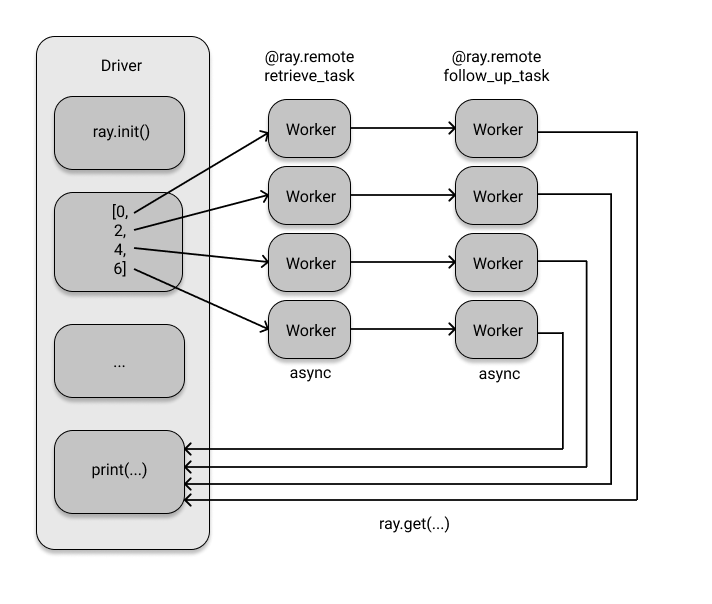

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time

import ray

In [ ]:
ray.init(num_cpus=4, ignore_reinit_error=True)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

2025-11-01 09:40:32,037	INFO worker.py:1850 -- Calling ray.init() again after it has already been called.


In [ ]:
@ray.remote
def load_data(filename):
    time.sleep(0.1)
    return np.ones((1000, 100))

@ray.remote
def normalize_data(data):
    time.sleep(0.1)
    return data - np.mean(data, axis=0)

@ray.remote
def extract_features(normalized_data):
    time.sleep(0.1)
    return np.hstack([normalized_data, normalized_data ** 2])

@ray.remote
def compute_loss(features):
    num_data, dim = features.shape
    time.sleep(0.1)
    return np.sum((np.dot(features, np.ones(dim)) - np.ones(num_data)) ** 2)

assert hasattr(load_data, 'remote'), 'load_data must be a remote function'
assert hasattr(normalize_data, 'remote'), 'normalize_data must be a remote function'
assert hasattr(extract_features, 'remote'), 'extract_features must be a remote function'
assert hasattr(compute_loss, 'remote'), 'compute_loss must be a remote function'

In [ ]:
start_time = time.time()
losses = []
for filename in ['file1', 'file2', 'file3', 'file4']:
    inner_start = time.time()

    data = load_data.remote(filename)
    normalized_data = normalize_data.remote(data)
    features = extract_features.remote(normalized_data)
    loss = compute_loss.remote(features)
    losses.append(loss)

    inner_end = time.time()

    if inner_end - inner_start >= 0.1:
        raise Exception('You may be calling ray.get inside of the for loop! '
                        'Doing this will prevent parallelism from being exposed. '
                        'Make sure to only call ray.get once outside of the for loop.')

print('The losses are {}.'.format(losses) + '\n')
loss = sum(ray.get(losses))

duration = time.time() - start_time

print('The loss is {}. This took {:.3f} seconds. Run the next cell to see '
      'if the exercise was done correctly.'.format(loss, duration))

The losses are [ObjectRef(82891771158d68c1ffffffffffffffffffffffff0100000001000000), ObjectRef(1e8ff6d236132784ffffffffffffffffffffffff0100000001000000), ObjectRef(71b133a11e1c461cffffffffffffffffffffffff0100000001000000), ObjectRef(1e360ffa862f8fe3ffffffffffffffffffffffff0100000001000000)].

The loss is 4000.0. This took 0.542 seconds. Run the next cell to see if the exercise was done correctly.


In [ ]:
assert loss == 4000
assert duration < 0.8, ('The loop took {:.3f} seconds. This is too slow.'
                        .format(duration))
assert duration > 0.4, ('The loop took {:.3f} seconds. This is too fast.'
                        .format(duration))

print('Success! The example took {:.3f} seconds.'.format(duration))

Success! The example took 0.542 seconds.


In [ ]:
ray.timeline(filename="exercise_2.json")

### Parallel web-scraping

One useful application of what we have learned so far is to scrape information from the web. Thos will be illustrated in a toy setting, but the same principles apply on a large scale where crawling through websites, parsing them and extracting useful content (e.g. for building a search index or populating a database) is often very computationally demanding.

We break up the process into multiple steps. First grab the raw HTML of the website using Python's requests package. Then, we use BeautifulSoup to parse the HTML to find the relevant information. Finally, we populate a pandas DataFrames so that we are able to work with the data.

To demonstrate this, we scrape GitHub commits to see the latest commits on several repositories.

In [ ]:
from bs4 import BeautifulSoup
import requests

import pandas as pd

The following function uses these libraries to parse the latest commits from several repositories on GitHub.

In [ ]:
import requests
import pandas as pd

@ray.remote
def fetch_commits_remote(repo):
    url = f'https://api.github.com/repos/{repo}/commits'

    headers = {'Accept': 'application/vnd.github.v3+json'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for bad status codes
    except requests.exceptions.RequestException as e:
        print(f"Error fetching commits for {repo}: {e}")
        return pd.DataFrame(columns=['title', 'link', 'repository'])

    data = response.json()
    commits_list = []
    for commit_data in data:
        commit_details = {
            'title': commit_data['commit']['message'].split('\n')[0],
            'link': commit_data['html_url'],
            'repository': repo
        }
        commits_list.append(commit_details)

    df = pd.DataFrame(commits_list)
    return df



Let's try this out to get results for some ray related topics serially.

In [ ]:
start = time.time()
repos = ["ray-project/ray", "modin-project/modin", "tensorflow/tensorflow", "apache/arrow"]
results = []
for repo in repos:
    df = fetch_commits_remote.remote(repo)
    results.append(df)

df = pd.concat(ray.get(results), sort=False)
duration = time.time() - start
print("Constructing the dataframe took {:.3f} seconds.".format(duration))

Constructing the dataframe took 0.214 seconds.


In [ ]:
df

,title,link,repository
0,"Revert ""[ci] enabling python 3.10 for subset o...",https://github.com/ray-project/ray/commit/4c82...,ray-project/ray
1,[release] release data batch inference tests (...,https://github.com/ray-project/ray/commit/507c...,ray-project/ray
2,[air] enable a test that was mistakenly disabl...,https://github.com/ray-project/ray/commit/6efc...,ray-project/ray
3,[doc][rdt] Add the limitations of rdt (#58063),https://github.com/ray-project/ray/commit/f38b...,ray-project/ray
4,[core][doc] add actor+job+node event to ray ev...,https://github.com/ray-project/ray/commit/7795...,ray-project/ray
...,...,...,...
25,GH-47840: [CI][C++] Check whether the CSV modu...,https://github.com/apache/arrow/commit/bab5580...,apache/arrow
26,GH-47572: [C++][Parquet] Uniform unpack interf...,https://github.com/apache/arrow/commit/7a38744...,apache/arrow
27,GH-47726 : [C++][FlightRPC] ODBC Unicode Suppo...,https://github.com/apache/arrow/commit/fc5fd48...,apache/arrow
28,GH-47784: [C++] Patch vendored pcg library to ...,https://github.com/apache/arrow/commit/541cba8...,apache/arrow


#Nested Parallelism

We will implement the structure of a parallel hyperparameter sweep which trains a number of models in parallel. Each model will be trained using parallel gradient computations.

### Nested Remote Functions

Remote functions can call other functions. For example, consider the following.

```python
@ray.remote
def f():
    return 1

@ray.remote
def g():
    # Call f 4 times and return the resulting object IDs.
    results = []
    for _ in range(4):
      results.append(f.remote())
    return results

@ray.remote
def h():
    # Call f 4 times, block until those 4 tasks finish,
    # retrieve the results, and return the values.
    results = []
    for _ in range(4):
      results.append(f.remote())
    return ray.get(results)
```

Then calling `g` and `h` produces the following behavior.

```python
>>> ray.get(g.remote())
[ObjectID(b1457ba0911ae84989aae86f89409e953dd9a80e),
 ObjectID(7c14a1d13a56d8dc01e800761a66f09201104275),
 ObjectID(99763728ffc1a2c0766a2000ebabded52514e9a6),
 ObjectID(9c2f372e1933b04b2936bb6f58161285829b9914)]

>>> ray.get(h.remote())
[1, 1, 1, 1]
```

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time

import ray

In [ ]:
ray.init(num_cpus=9, ignore_reinit_error=True)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

2025-11-01 09:43:24,084	INFO worker.py:1850 -- Calling ray.init() again after it has already been called.


In [ ]:
@ray.remote
def compute_gradient(data, current_model):
    time.sleep(0.03)
    return 1

@ray.remote
def train_model(hyperparameters):
    current_model = 0
    # Iteratively improve the current model. This outer loop cannot be parallelized.
    for _ in range(10):
        # to get all of the results in order to compute the updated model (by taking
        # the sum), so it's ok to call ray.get() inside of the loop here.
        gradients = []
        for j in range(2):
            gradients.append(compute_gradient.remote(j, current_model))
        current_model += sum(ray.get(gradients))

    return current_model

assert hasattr(compute_gradient, 'remote'), 'compute_gradient must be a remote function'
assert hasattr(train_model, 'remote'), 'train_model must be a remote function'

In [ ]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

# Run some hyperparaameter experiments.
results = []
for hyperparameters in [{'learning_rate': 1e-1, 'batch_size': 100},
                        {'learning_rate': 1e-2, 'batch_size': 100},
                        {'learning_rate': 1e-3, 'batch_size': 100}]:
    results.append(train_model.remote(hyperparameters))

# turned "results" into a list of Ray ObjectIDs
# by calling train_model.remote, you will need to turn "results" back
# into a list of integers, e.g., by doing "results = ray.get(results)".

end_time = time.time()

results = ray.get(results)

duration = end_time - start_time

assert all([isinstance(x, int) for x in results]), \
    'Looks like "results" is {}. You may have forgotten to call ray.get.'.format(results)

In [ ]:
print(results)

[20, 20, 20]


In [ ]:
assert results == [20, 20, 20]

print('Success! The example took {:.3f} seconds.'.format(duration))

Success! The example took 0.002 seconds.


In [ ]:
ray.timeline(filename="exercise_3.json")

Ray.wait()

This call will block ONLY until the *first* task completes.

It returns two lists:
1. ready_refs: A list of ObjectIDs that are ready.
2. remaining_refs: A list of ObjectIDs that are not yet ready.

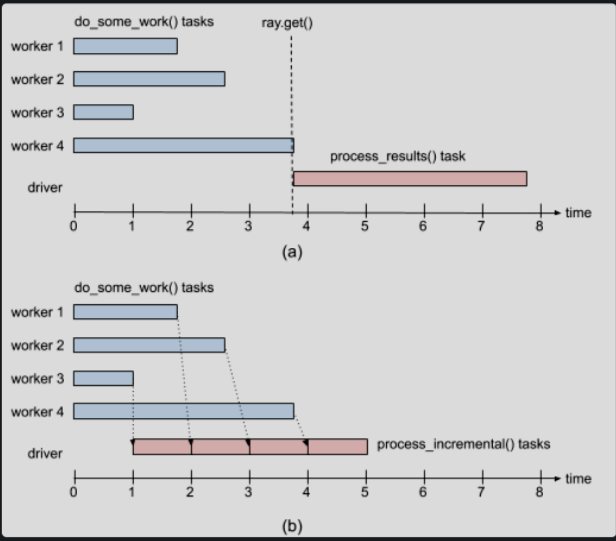

In [ ]:
import random

In [ ]:
ray.init(ignore_reinit_error=True)

@ray.remote
def slow_task(task_index):
    # Simulate a task with a random duration
    sleep_time = random.uniform(1, 5)
    time.sleep(sleep_time)
    print(f"Task {task_index} finished after {sleep_time:.2f} seconds.")
    return (task_index, sleep_time)

print("Starting 5 slow tasks in parallel...")
task_refs = []
for i in range(5):
    task_refs.append(slow_task.remote(i))

print(f"All 5 tasks launched: {task_refs}")
print("Waiting for the FIRST task to finish using ray.wait()...")

ready_refs, remaining_refs = ray.wait(task_refs)

print(f"Ready refs: {ready_refs}")
print(f"Remaining refs: {remaining_refs}")

# You can now get the result of the finished task immediately
first_result = ray.get(ready_refs[0])
print(f"Result from the first completed task: {first_result}")


2025-11-01 09:47:09,481	INFO worker.py:1850 -- Calling ray.init() again after it has already been called.


Starting 5 slow tasks in parallel...
All 5 tasks launched: [ObjectRef(91581beb08e6c9deffffffffffffffffffffffff0100000001000000), ObjectRef(ae46b8beecd25f3affffffffffffffffffffffff0100000001000000), ObjectRef(aa3d5d11e415fe88ffffffffffffffffffffffff0100000001000000), ObjectRef(a6d6d59239756144ffffffffffffffffffffffff0100000001000000), ObjectRef(c7528efcb2fd36edffffffffffffffffffffffff0100000001000000)]
Waiting for the FIRST task to finish using ray.wait()...
Ready refs: [ObjectRef(a6d6d59239756144ffffffffffffffffffffffff0100000001000000)]
Remaining refs: [ObjectRef(91581beb08e6c9deffffffffffffffffffffffff0100000001000000), ObjectRef(ae46b8beecd25f3affffffffffffffffffffffff0100000001000000), ObjectRef(aa3d5d11e415fe88ffffffffffffffffffffffff0100000001000000), ObjectRef(c7528efcb2fd36edffffffffffffffffffffffff0100000001000000)]
Result from the first completed task: (3, 1.3325419863419872)


In [ ]:
remaining_results = ray.get(remaining_refs)
print(f"Results from remaining tasks: {remaining_results}")

Results from remaining tasks: [(0, 3.931415129821694), (1, 3.7976742307199705), (2, 2.366926594324788), (4, 4.360985778034959)]


ray.put() stores the object in Ray's object store ONCE.

This returns a lightweight reference (an ObjectID).

In [ ]:
ray.init(ignore_reinit_error=True)

@ray.remote
def process_large_data(data, task_index):
    # This function receives the actual NumPy array
    print(f"Task {task_index}: Received data with shape {data.shape}")
    time.sleep(1)
    return np.mean(data)

large_array = np.random.rand(5000, 2500)
print(f"Original array size: {large_array.nbytes / 1e6:.2f} MB")


large_array_ref = ray.put(large_array)

print(f"Object reference: {large_array_ref}")
print("-" * 30)

# Ray is smart enough to see the reference and send the data
# to the worker nodes only once.
task_refs = []
for i in range(4):
    # We pass the same 'large_array_ref' to all tasks.
    task_refs.append(process_large_data.remote(large_array_ref, i))

results = ray.get(task_refs)
print(f"Results: {results}")



2025-11-01 09:48:04,789	INFO worker.py:1850 -- Calling ray.init() again after it has already been called.


Original array size: 100.00 MB
Object reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505)
------------------------------
(process_large_data pid=46005) Task 0: Received data with shape (5000, 2500)
Results: [np.float64(0.5000237584460857), np.float64(0.5000237584460857), np.float64(0.5000237584460857), np.float64(0.5000237584460857)]


In [ ]:
ray.shutdown()